# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Испортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

Прочитаем данные с файлов и сохраним в data.

In [2]:
data0 = pd.read_csv("/datasets/geo_data_0.csv")
data1 = pd.read_csv("/datasets/geo_data_1.csv")
data2 = pd.read_csv("/datasets/geo_data_2.csv")

Посмотрим общую информацию о файлах.

In [3]:
data0.info()
data0.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


Согласно документации к данным, в таблице `geo_data_0` содержатся следующие столбцы:
* `id` — уникальный идентификатор скважины
* `f0, f1, f2` — три признака точек
* `product` — объём запасов в скважине (тыс. баррелей).

In [4]:
data1.info()
data1.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


Согласно документации к данным, в таблице `geo_data_1` содержатся следующие столбцы:
* `id` — уникальный идентификатор скважины
* `f0, f1, f2` — три признака точек
* `product` — объём запасов в скважине (тыс. баррелей).

In [5]:
data2.info()
data2.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


Согласно документации к данным, в таблице `geo_data_2` содержатся следующие столбцы:
* `id` — уникальный идентификатор скважины
* `f0, f1, f2` — три признака точек
* `product` — объём запасов в скважине (тыс. баррелей).

Простмотрев общую информацию о данных, каких либо осбенно ярких проблем не выделяется.
Проверим наличие/отсутвие пропущенных значений.

In [6]:
data0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [7]:
data1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [8]:
data2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Проверка показывает, что ни в одном датафрейме пропущенных значений нет.

Проверим наличие дубликатов.

In [9]:
print("Количество дубликатов в data0:", data0.duplicated().sum())
print("Количество дубликатов в data1:", data1.duplicated().sum())
print("Количество дубликатов в data2:", data2.duplicated().sum())

Количество дубликатов в data0: 0
Количество дубликатов в data1: 0
Количество дубликатов в data2: 0


Ни в одной таблице дубликатов не обнаружено. 


Визуализируем данные.

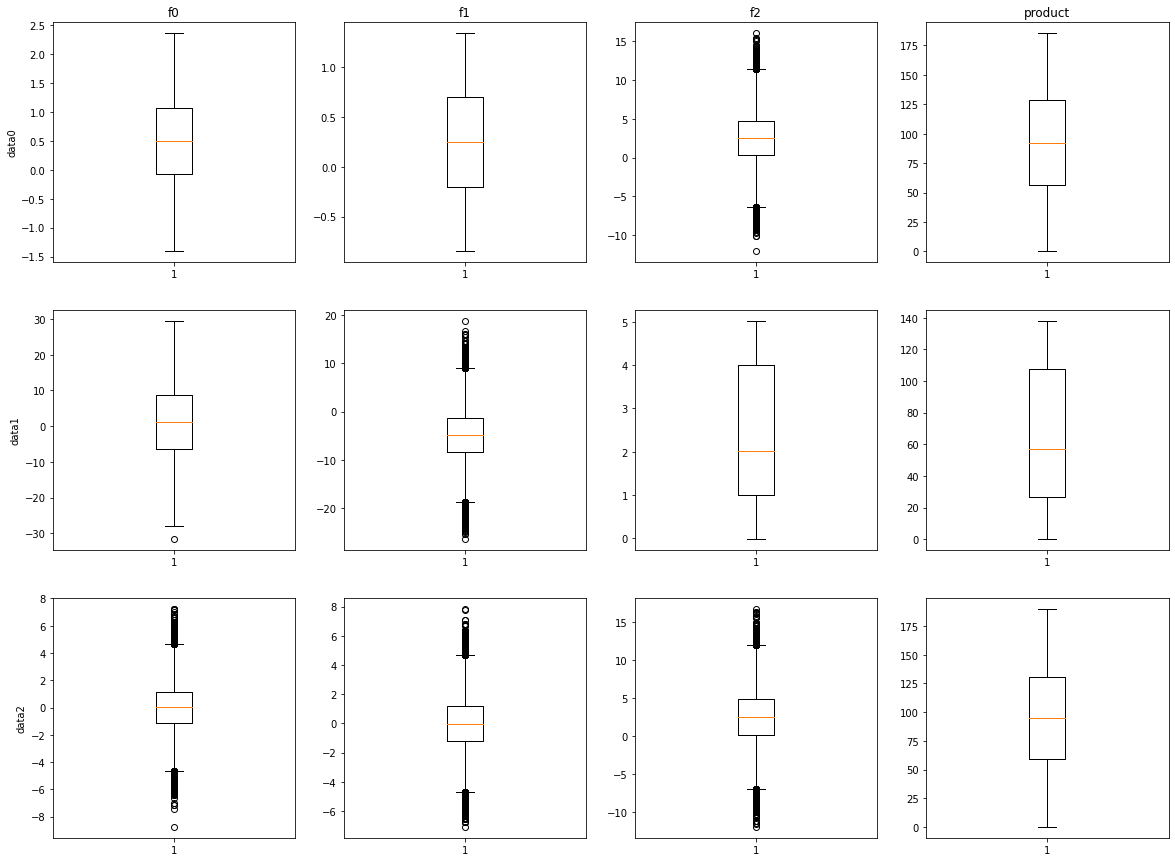

In [10]:
fig,ax = plt.subplots(3,4,figsize = (20,15))

all_frames = ["data0","data1","data2"]
num_columns = data0.columns[1:]
num_columns_with_columns = zip(data0.columns[1:],range(4))
all_frames_with_rows = zip([data0, data1, data2],range(3))

# графики
for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
    
# название 
for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])
for column in range(4):
    ax[0][column].set_title(num_columns[column])

Присутствуют небольшие выбросы. Так как неизвестно, что означают сами признаки, сложно оценить адекватность распределений и выбросов.
Масштабы распределений признаков f0, f1, f2 не сильно отличаются друг от друга. Нет необходимости применять масштабирование.


В таблицах есть столбец `id`, который не будет нести информации для обучения модели, поэтому удалим его.

In [11]:
data0 = data0.drop(['id'], axis=1)
data1 = data1.drop(['id'], axis=1)
data2 = data2.drop(['id'], axis=1)

**Вывод этапа**:
- Проведена проверка данных на начличие пропущенных значений и дубликатов. Нигде пропусков и повторений не обнаружено.
- Проверено распределение признаков. Обнаружены многочисленные выбросы.

## Обучение и проверка модели

Разделим данные на признаки и атрибуты.

In [12]:
feature_names = ['f0', 'f1', 'f2']
target_name = ['product']

feature0 = data0[feature_names]
target0 = data0[target_name]

feature1 = data1[feature_names]
target1 = data1[target_name]

feature2 = data2[feature_names]
target2 = data2[target_name]

Для каждого региона:

- Разделим данные на обучающую и валидационную выборки
- Используем модель линейной регрессии.
- Выведем средний запас предсказанного сырья и RMSE модели.

**Data0**

In [13]:
feature_train0, feature_valid0, target_train0, target_valid0 = train_test_split(feature0,target0,test_size=0.25,random_state=42)
print('Тренировочная выборка:', feature_train0.shape)
print('Валидационная выборка:', feature_valid0.shape)
    
model0 = LinearRegression()
model0.fit(feature_train0, target_train0)
predict0 = model0.predict(feature_valid0)

predict_mean0 = predict0.mean()
rmse0 = mean_squared_error(target_valid0, predict0)**.5

print('Cредний запас предсказанного сырья:', predict_mean0)
print('RMSE модели:', rmse0)

Тренировочная выборка: (75000, 3)
Валидационная выборка: (25000, 3)
Cредний запас предсказанного сырья: 92.39879990657768
RMSE модели: 37.75660035026169


**Data1**

In [14]:
feature_train1, feature_valid1, target_train1, target_valid1 = train_test_split(feature1,target1,test_size=0.25,random_state=42)
print('Тренировочная выборка:', feature_train1.shape)
print('Валидационная выборка:', feature_valid1.shape)
    
model1 = LinearRegression()
model1.fit(feature_train1, target_train1)
predict1 = model1.predict(feature_valid1)

predict_mean1 = predict1.mean()
rmse1 = mean_squared_error(target_valid1, predict1)**.5

print('Cредний запас предсказанного сырья:', predict_mean1)
print('RMSE модели:', rmse1)

Тренировочная выборка: (75000, 3)
Валидационная выборка: (25000, 3)
Cредний запас предсказанного сырья: 68.71287803913762
RMSE модели: 0.890280100102884


**Data2**

In [15]:
feature_train2, feature_valid2, target_train2, target_valid2 = train_test_split(feature2,target2,test_size=0.25,random_state=42)
print('Тренировочная выборка:', feature_train2.shape)
print('Валидационная выборка:', feature_valid2.shape)
    
model2 = LinearRegression()
model2.fit(feature_train2, target_train2)
predict2 = model2.predict(feature_valid2)

predict_mean2 = predict2.mean()
rmse2 = mean_squared_error(target_valid2, predict2)**.5

print('Cредний запас предсказанного сырья:', predict_mean2)
print('RMSE модели:', rmse2)

Тренировочная выборка: (75000, 3)
Валидационная выборка: (25000, 3)
Cредний запас предсказанного сырья: 94.77102387765939
RMSE модели: 40.145872311342174


**Вывод этапа**:
Нулевой регион:
- Показатель сырья - 92.4
- Показатель RMSE - 37.8
Такие высокие значения свидетельствуют о неоднозначности показателя, неточности модели регрессии.<br>
<br>
Первый регион:
- Показатель сырья - 68.7
- Показатель RMSE - 0.9
RMSE довольно маленький, что говорит о точности и качестве модели.<br>
<br>
Второй регион:
- Показатель сырья - 94.8
- Показатель RMSE - 40.1
Такие высокие значения свидетельствуют о неоднозначности показателя, неточности модели регрессии.<br>

## Подготовка к расчёту прибыли

- min_product = budget / (top_wells * unit_income)
- budget - Бюджет на разработку скважин в регионе — 10 млрд рублей
- top_wells, samp_wells - При расчёте выбирают 200 лучших скважин из 500 в выборке
- unit_income - Доход с каждой единицы продукта составляет 450 тыс. рублей

In [16]:
BUDGET = 10**10
TOP_WELLS = 200
SAMP_WELLS = 500
UNIT_INCOME = 450000
DAMAGE_THRESHOLD =  0.025
MIN_PROTUCT = BUDGET/(UNIT_INCOME*TOP_WELLS)

In [17]:
print('Минимальный объём продукта с одной скважины для безубыточной разработки:', MIN_PROTUCT)

Минимальный объём продукта с одной скважины для безубыточной разработки: 111.11111111111111


**Вывод этапа**:
Минимальный объём продукта для безубыточной разработки составляет 111.11.
Данное значение превышает средние значения запасов скважин по всем регионам.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

- Выберем скважины с максимальными значениями предсказаний. Количество скважин зависит от бюджета компании и стоимости разработки одной скважины. В нашем случае выберем случайно 500 точек и отберём 200 с максимальным показателем объёма сырья
- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитаем прибыль для полученного объёма сырья.

In [18]:
target_valid0 = pd.Series(target_valid0['product']).reset_index(drop=True)
target_valid1 = pd.Series(target_valid1['product']).reset_index(drop=True)
target_valid2 = pd.Series(target_valid2['product']).reset_index(drop=True)

predict0 = pd.Series(*predict0.reshape(1,-1))
predict1 = pd.Series(*predict1.reshape(1,-1))
predict2 = pd.Series(*predict2.reshape(1,-1))

In [19]:
def show_predicted_income(top_wells_mean, volume, income):
    print('Средний запас сырья:', top_wells_mean)
    print('Суммарный целевой объём сырья:', volume)
    print('Прибыль для полученного объёма сырья:', income)

In [20]:
def predicted_income(target, predicts, state = 42, pok = True):
    sample_preds = predicts.sample(n = SAMP_WELLS, replace = True, random_state = state)
    preds = sample_preds.sort_values(ascending=False)[:TOP_WELLS]
    top_targets = target[preds.index]
    top_wells_mean = top_targets.mean()
    volume = sum(top_targets)
    income = volume * UNIT_INCOME - BUDGET
    if pok == True:
        show_predicted_income(top_wells_mean, volume, income)
    else: 
        return income

In [21]:
print('Регион 0')
predicted_income(target_valid0, predict0)

Регион 0
Средний запас сырья: 117.46420066477886
Суммарный целевой объём сырья: 23492.840132955753
Прибыль для полученного объёма сырья: 571778059.8300896


In [22]:
print('Регион 1')
predicted_income(target_valid1, predict1)

Регион 1
Средний запас сырья: 118.78924134931037
Суммарный целевой объём сырья: 23757.84826986213
Прибыль для полученного объёма сырья: 691031721.4379578


In [23]:
print('Регион 2')
predicted_income(target_valid2, predict2)

Регион 2
Средний запас сырья: 110.80099354526509
Суммарный целевой объём сырья: 22160.198709053013
Прибыль для полученного объёма сырья: -27910580.926143646


Теперь расчитаем риски. Применим Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [24]:
def show_risks(income_mean, conf_int_left, conf_int_right, loss_rate):
    print('Средняя прибыль:', income_mean / 10**6)
    print('95% доверительный интервал:','%.3f' % (conf_int_left / 10**6), '%.3f' %(conf_int_right / 10**6))
    print('Риск убытков:', '%.3f' %(loss_rate * 100))

In [25]:
def risk_calc(target, predicts):
    bootstrap_samples = 1000
    alpha = 0.05
    incomes = []
    state = np.random.RandomState(42)
    for _ in range(bootstrap_samples):
        income = predicted_income(target, predicts, state, False)
        incomes.append(income)

    incomes = pd.Series(incomes)
    income_mean = incomes.mean()
    conf_int_left = incomes.quantile(alpha/2)
    conf_int_right = incomes.quantile(1 - alpha/2)
    
    loss_count = 0
    for inc in incomes :
        if inc < 0 :
            loss_count += 1
    loss_rate = loss_count / bootstrap_samples 
    
    show_risks(income_mean, conf_int_left, conf_int_right, loss_rate)

In [26]:
risk_calc(target_valid0, predict0)

Средняя прибыль: 399.5754780542297
95% доверительный интервал: -110.468 897.460
Риск убытков: 6.000


In [27]:
risk_calc(target_valid1, predict1)

Средняя прибыль: 452.04889090648027
95% доверительный интервал: 61.684 845.340
Риск убытков: 1.500


In [28]:
risk_calc(target_valid2, predict2)

Средняя прибыль: 375.00990291532827
95% доверительный интервал: -144.767 888.390
Риск убытков: 8.000


**Вывод этапа**:
- Написаны функции расчета прибыли и рисков
- Рассчитан средний запас сырья с одной скважины среди всех регионов 0: 117.5, 1: 118.8, 2: 111.8, что превосходит минимально необходимый объём 111.11.

Самым выгодным регионом оказался Регион 1 с оценкой средней прибыли 452.05 млн. с риском убытков всего в 1.5%. Следовательно именно Регион 1 рекомендуется к разработке.

**Общий вывод** <br>

Итак, полученный архив данных -данные о скважинах нескольких регионов.

На этапе предобработки проведена проверка данных на начличие пропущенных значений и дубликатов. Нигде пропусков и повторений не обнаружено. Построено распределение признаков. Обнаружены многочисленные выбросы. Однако из-за того, что неизвестно, что именно означают сами признаки, оценить адекватность распределений и выбросов точно нельзя. Данные оставлены без изменений.

На этпе обучения модели выделен целевой признак `product` и атрибуты будущих моделей. Обучены модели на основе линейной регрессии и найдены показатели регионов.
Нулевой регион:
- Показатель сырья - 92.4
- Показатель RMSE - 37.8
Такие высокие значения свидетельствуют о неоднозначности показателя, неточности модели регрессии.<br>
<br>
Первый регион:
- Показатель сырья - 68.7
- Показатель RMSE - 0.9
RMSE довольно маленький, что говорит о точности и качестве модели.<br>
<br>
Второй регион:
- Показатель сырья - 94.8
- Показатель RMSE - 40.1
Такие высокие значения свидетельствуют о неоднозначности показателя, неточности модели регрессии.<br>

На этапе расчета прибыли был найден минимальный объём продукта для безубыточной разработки - 111.11, написаны функции расчета прибыли и рисков.<br>
Рассчитан средний запас сырья с одной скважины среди всех регионов Регион 0: 117.5, 1: 118.8, 2: 111.8, что превосходит минимально необходимый объём 111.11.

Самым выгодным регионом оказался Регион 1 с оценкой средней прибыли 452.05 млн. с риском убытков всего в 1.5%. Следовательно именно Регион 1 рекомендуется к разработке.